# Kickstarter Projects
# Day 2 (Rev-2-2 SVM RBF) Homework for a Machine Learning Course
Author：Hiroki Miyamoto

# Summary

In this notebook, SVM RBF Kernel was re-calculated with max_iter=-1(default). As a result, it was confirmed that SVM could predict slightly better accuracy as logistic regression.

| Model | Final Test Accuracy   |
|------|------|
|   Logistic Regression (L1)  | 68.929% |
|   Logistic Regression (L2)  | 68.932% |
|   ~~SVM (Linear) max_iter=2000~~  | ~~61.953%~~ |
|   SVM (Linear) max_iter=-1(default : no limit) |  68.797%  |
|   ~~SVM (RBF) max_iter=2000~~  | ~~60.256%~~ |
|   **SVM (RBF) max_iter=-1(default : no limit)**  | **69.226%** |

- Objective variable
    - state_dummy (successful = 1, other = 0)
- Explanatory variables
    - usd_goal_real_log10
        - Second highly contributed variable to predict
    - category_dummy
        - is created by aggregating success rate of each category in training phase
        - First highly contributed variable to predict
        


# Links to my homeworks
- Kaggle
    - Day1
        - Objective of Day 1 : Build a supervised machine learning model based on the lecture on Day 1. Don't care about the accuracy for now.
        - https://www.kaggle.com/hmiyamoto/day-1-homework-for-a-machine-learning-course/
    - Day2
        - Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-for-a-machine-learning-course/
    - Day2 Appendix-1
        - Check the contribution of explanatory variables for prediction by investigating the weight
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-1
    - Day2 Appendix-2
        - Check the contribution of explanatory variables for prediction by investigating the weight again
            - "backers" and "usd_pledged_real" are removed from explanatory variables for success prediction because these variables are results of funding.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-2
- GitHub
    - https://github.com/hmiyamoto1/skillupai_ml

## Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.

### "backers" and "usd_pledged_real" are removed from explanatory variables for success prediction because these variables are results of funding, as examined in the notebook Day 2 Appendix-2. 

### 2-variables 'category_dummy' and 'usd_goal_real_log10' are applied as explanatory variables because these variables are highly contributed to predict, as examined in the notebook Day 2 Appendix-2. 

### Table of Contents (Day 2)
1. Devide dataframe into train data(train & validation) and test data(final check)
1. Parameter study for Logistic Regression (L1)
1. Parameter study for Logistic Regression (L2)
1. Parameter study for SVM (Linear)
1. Parameter study for SVM (RBF)

# 0. Preparation

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ( 'x', '.', 'o', 's', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
                       
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    edgecolor=None,
                    marker=markers[idx], 
                    label=cl)

# 1. Devide dataframe into train data(trian & validation) and test data(final check)
- DataFrame
    - df_TRAIN : 80%
        - This will be further devided into train and validation data in holdout or cross-validation training phase.
            - train : 80%
            - valid : 20%
    - df_TEST : 20%
        - This is blind data for final test.

## Acquire data

In [3]:
df_kick = pd.read_csv("../input/ks-projects-201801.csv")

## Preview the data

In [4]:
display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Create dataframe with selected features

In [5]:
df_kick['state_dummy'] = df_kick['state']
df_kick['state_dummy'].loc[df_kick['state_dummy'] != 'successful'] = 0
df_kick['state_dummy'].loc[df_kick['state_dummy'] == 'successful'] = 1

# display(df_kick.head())

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# epsilon = 1e-8
epsilon = 1

df_kick['usd_goal_real_log10'] = np.log10(df_kick['usd_goal_real'] + epsilon)

display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_dummy,usd_goal_real_log10
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,3.186094
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,4.477136
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,4.653222
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,3.699057
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0,4.290057


In [7]:
df_ALL = df_kick.loc[:, ['state_dummy', 'usd_goal_real_log10', 'category']]
df_ALL.head()

,state_dummy,usd_goal_real_log10,category
0,0,3.186094,Poetry
1,0,4.477136,Narrative Film
2,0,4.653222,Narrative Film
3,0,3.699057,Music
4,0,4.290057,Film & Video


In [8]:
df_TRAIN, df_TEST = train_test_split(df_ALL, test_size=0.2, random_state=1234)
df_TRAIN.head()
display(df_TRAIN.describe())
display(df_TEST.describe())

,state_dummy,usd_goal_real_log10
count,302928.000000,302928.000000
mean,0.354229,3.750413
std,0.478280,0.734916
min,0.000000,0.004321
25%,0.000000,3.301247
50%,0.000000,3.739286
75%,1.000000,4.188782
max,1.000000,8.221053


,state_dummy,usd_goal_real_log10
count,75733.000000,75733.000000
mean,0.351894,3.752895
std,0.477564,0.733179
min,0.000000,0.173186
25%,0.000000,3.301247
50%,0.000000,3.740442
75%,1.000000,4.201308
max,1.000000,8.000000


# 5. Parameter study for SVM (RBF)
- Model
    - Variables
        - Objective variable
            - state_dummy (successful = 1, other = 0)
        - Explanatory variables
            - usd_goal_real_log10
                - Second highly contributed variable to predict
            - category_dummy
                - will be created by aggregating success rate of each category in training phase
                - First highly contributed variable to predict
    - **SVM (RBF) is applied here.**
    - **Holdout method is applied for SVM parameter study instead of cross validation to shorten the calculation time.**
- Cross Validation Result
    - Best parameter
        - **C = 1e2  (1e-4 <= C <= 1e2)**
        - **gamma = 1e-8  (1e-10 <= gamma <= 1e-4)**
    - Best score
        - **Holdout Log-likelihood = -10.894**
        - **Holdout Accuracy = 68.460%**
- Final Test Result (Applied best parameter)
    - Test score
        - **Test Log-likelihood = -13.727**
        - **Test Accuracy = 60.256%**

## Holdout Method

kernel = rbf
C = 0.1
gamma = 0.1



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


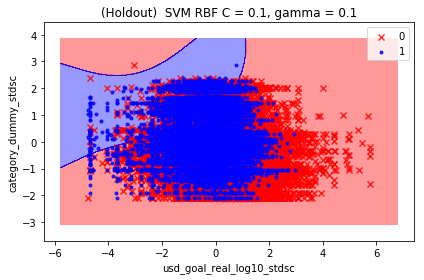

Holdout Log-likelihood = -10.92
Holdout Accuracy = 68.384%
kernel = rbf
C = 0.1
gamma = 1.0



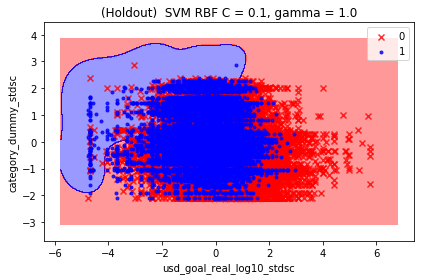

Holdout Log-likelihood = -10.886
Holdout Accuracy = 68.483%
kernel = rbf
C = 0.1
gamma = 10.0



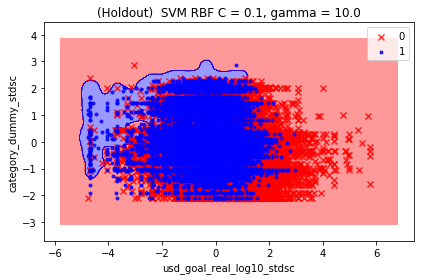

Holdout Log-likelihood = -10.83
Holdout Accuracy = 68.645%
kernel = rbf
C = 1.0
gamma = 0.1



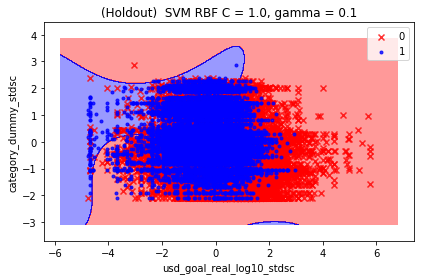

Holdout Log-likelihood = -10.938
Holdout Accuracy = 68.331%
kernel = rbf
C = 1.0
gamma = 1.0



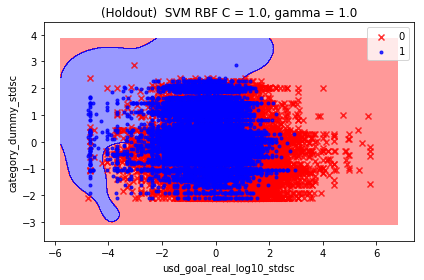

Holdout Log-likelihood = -10.87
Holdout Accuracy = 68.527%
kernel = rbf
C = 1.0
gamma = 10.0



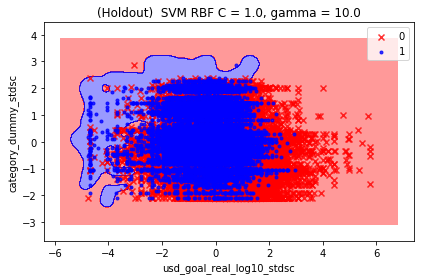

Holdout Log-likelihood = -10.847
Holdout Accuracy = 68.595%
kernel = rbf
C = 10.0
gamma = 0.1



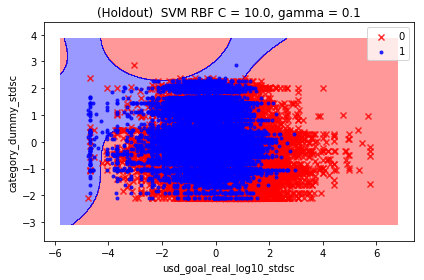

Holdout Log-likelihood = -10.932
Holdout Accuracy = 68.349%
kernel = rbf
C = 10.0
gamma = 1.0



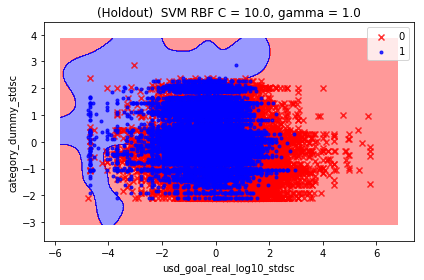

Holdout Log-likelihood = -10.874
Holdout Accuracy = 68.517%
kernel = rbf
C = 10.0
gamma = 10.0



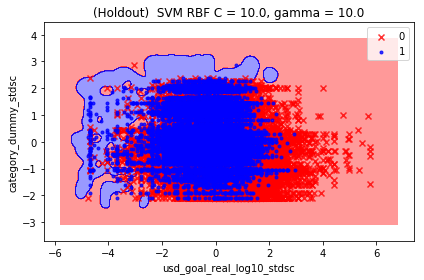

Holdout Log-likelihood = -10.854
Holdout Accuracy = 68.575%
CPU times: user 21h 38min 55s, sys: 8min 33s, total: 21h 47min 28s
Wall time: 21h 51min 8s


In [9]:
%%time
kernel = 'rbf'
# Cs = np.logspace(-4, 2, 7, base=10)
# gammas = np.logspace(-10, -4, 7, base=10)
Cs = np.logspace(-1, 1, 3, base=10)
gammas = np.logspace(-1, 1, 3, base=10)

SVM_accuracy = []
SVM_log_likelihood = []
SVM_weight_abs_max = []
SVM_weight_abs_min = []


for C in Cs:
    for gamma in gammas:

        print('='*100)
        print('kernel =', kernel)
        print('C =', C)
        print('gamma =', gamma)
        print()

        y = df_TRAIN["state_dummy"].values
        X = df_TRAIN[["usd_goal_real_log10", "category"]].values

        # Holdout method
        test_size = 0.2        # 20%
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=1234) # Holdout


        df_X_train = pd.DataFrame(X_train,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_valid = pd.DataFrame(X_valid,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_valid = pd.DataFrame(y_valid,
                                 columns=["state_dummy"])


        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_valid['category_dummy'] = df_X_valid['category'].replace(category_success_rate)

        X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
        X_valid = df_X_valid[["usd_goal_real_log10", "category_dummy"]].values

        # Normaliztion
        stdsc = StandardScaler()
        X_train = stdsc.fit_transform(X_train)
        X_valid = stdsc.transform(X_valid)

        #clf = SVC(C=C,kernel=kernel, gamma=gamma, max_iter=2000, random_state=1234)
        clf = SVC(C=C,kernel=kernel, gamma=gamma, random_state=1234)
        clf.fit(X_train, y_train)

        # Predict labels
        y_est_valid = clf.predict(X_valid)

        # Log-likelihood
        holdout_log_likelihood = - log_loss(y_valid, y_est_valid)         

        # Accuracy
        holdout_accuracy = accuracy_score(y_valid, y_est_valid)

        plot_decision_regions(X_valid, y_valid, classifier=clf)
        plt.title('(Holdout)  SVM RBF C = %s, gamma = %s' %(C, gamma))
        plt.xlabel('usd_goal_real_log10_stdsc')
        plt.ylabel('category_dummy_stdsc')
        plt.axes().set_aspect('equal', 'datalim')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        # Generalization performance
        final_log_likelihood = holdout_log_likelihood
        print("Holdout Log-likelihood = %s"%round(final_log_likelihood, 3))
        final_accuracy = holdout_accuracy
        print('Holdout Accuracy = {:.3f}%'.format(100 * final_accuracy))

        SVM_accuracy.append(final_accuracy)
        SVM_log_likelihood.append(final_log_likelihood)

    

In [10]:
SVM_accuracy_2d = np.array(SVM_accuracy).reshape(3, 3)
Cs_str = list(map(str, Cs))
gammas_str = list(map(str, gammas))
df_SVM_accuracy_2d = pd.DataFrame(data=SVM_accuracy_2d, index=Cs_str, columns=gammas_str)
df_SVM_accuracy_2d

,0.1,1.0,10.0
0.1,0.683838,0.684828,0.686446
1.0,0.683310,0.685274,0.685951
10.0,0.683491,0.685175,0.685752


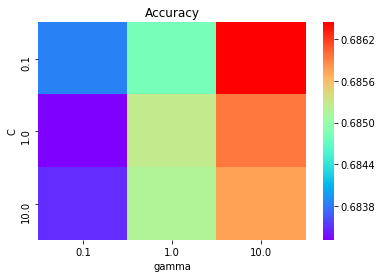

In [11]:
sns.heatmap(df_SVM_accuracy_2d, cmap='rainbow')
plt.ylabel("C")
plt.xlabel("gamma")
plt.title('Accuracy')
plt.show()

## Final Test

kernel = rbf
C = 0.1
gamma = 10



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Log-likelihood = -10.629
Test Accuracy = 69.226%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


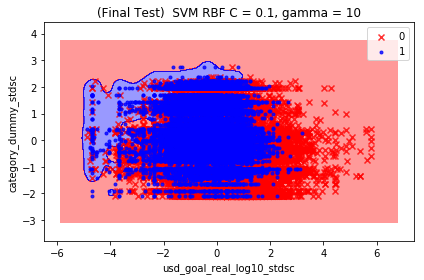

In [12]:
kernel = 'rbf'

# Best Parameter
C = 0.1
gamma = 10


print('kernel =', kernel)
print('C =', C)
print('gamma =', gamma)
print()

# TRAIN data
df_y_train = df_TRAIN[["state_dummy"]]
df_X_train = df_TRAIN[["usd_goal_real_log10", "category"]]

# TEST data
df_y_test = df_TEST[["state_dummy"]]
df_X_test = df_TEST[["usd_goal_real_log10", "category"]]

# Create dummy variables for category using train data
# Replace category to category_success_rate
category_success_rate = {}
df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
df_category_all_count = df_X_train['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)



X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
X_test = df_X_test[["usd_goal_real_log10", "category_dummy"]].values

y_train = df_y_train[["state_dummy"]].values
y_test = df_y_test[["state_dummy"]].values

# print(X_test.shape)
# print(y_test.flatten().shape)

# print(X_valid.shape)
# print(y_valid.shape)

# Normaliztion
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

#clf = SVC(C=C,kernel=kernel, gamma=gamma, max_iter=2000, random_state=1234)
clf = SVC(C=C,kernel=kernel, gamma=gamma, random_state=1234)
clf.fit(X_train, y_train)

# Predict labels
y_est_test = clf.predict(X_test)

# Log-likelihood
log_likelihood = - log_loss(y_test, y_est_test)       
print('Test Log-likelihood = {:.3f}'.format(log_likelihood))

# Accuracy
accuracy = accuracy_score(y_test, y_est_test)  
print('Test Accuracy = {:.3f}%'.format(100 * accuracy))
print()

plot_decision_regions(X_test, y_test.flatten(), classifier=clf)
plt.title('(Final Test)  SVM RBF C = %s, gamma = %s' %(C, gamma))
plt.xlabel('usd_goal_real_log10_stdsc')
plt.ylabel('category_dummy_stdsc')
plt.axes().set_aspect('equal', 'datalim')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

    